In [1]:
import numpy as np
import   matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from utils import getFiles

In [ ]:
res = np.load("/data/FLARE21/results/roughSegmenter/results_grid.npy")
res = res.reshape((5*18,5,2))
# code to delete empty entries (no labels in the gold standard)
np.delete(res, np.squeeze(np.argwhere(res[:,2,0]==-235)), axis=0).shape

In [ ]:
for organ_idx in range(5):
    plt.figure()
    plt.hist(np.delete(res, np.squeeze(np.argwhere(res[:,organ_idx,0]==-235)), axis=0)[:,organ_idx,1], bins=100)
plt.show()

In [ ]:
# Quick check
pdx = 31
slice = 32
for slice in range(36, 40, 2):
    patient = f"train_0{pdx}.npy"
    pred = np.load(os.path.join("/data/FLARE21/results/roughSegmenter/test_segs/", "pred_"+patient)).astype(float)
    ct = np.load(os.path.join("/data/FLARE21/training_data/scaled_ims/", patient))
    gs = np.load(os.path.join("/data/FLARE21/training_data/scaled_masks/", patient)).astype(float)
    fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(10,5))
    pred[pred<0.05] = np.nan
    gs[gs<0.05] = np.nan
    ax0.imshow(ct[slice], cmap='Greys_r')
    ax0.imshow(gs[slice], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.5)
    ax1.imshow(ct[slice], cmap='Greys_r')
    ax1.imshow(pred[slice], cmap='gist_rainbow', vmin=0, vmax=5, alpha=0.5)
    plt.show()

In [ ]:
# Check which labels are missing -> 3 cases of right kidney -> maybe this is the cause? -> train a model without blanking off these cases
labels_present = np.load("/data/FLARE21/training_data/labels_present.npy")
labels_present = labels_present[:92]
for i in range(92):
    if (labels_present[i]==False).any():
        print(i, labels_present[i])

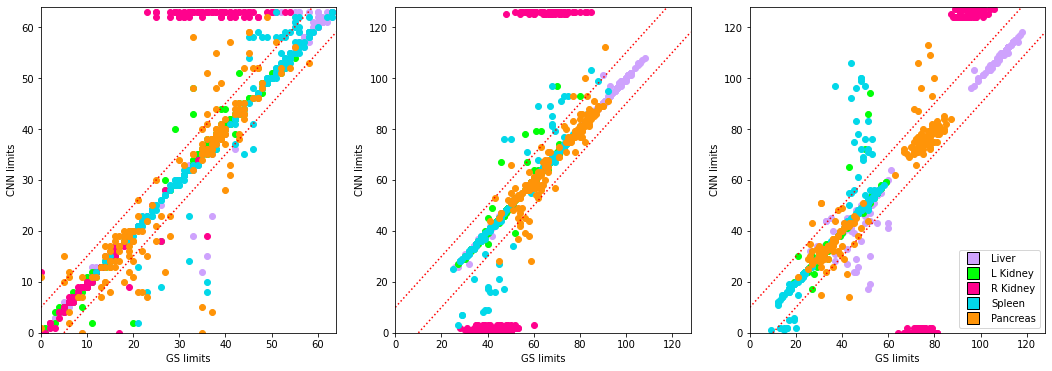

In [30]:
'''
Look at the bounding boxes created using the rough segmenter.
Use this to decide what postprocessing is necessary and how big to crop each box
'''
# first look at no postprocessing
fnames = sorted(getFiles("/data/FLARE21/results/roughSegmenter/test_segs/"))
res = np.full((len(fnames), 5, 3, 2, 2), fill_value=np.nan)
for pdx, fname in enumerate(fnames):
    pred = np.load(os.path.join("/data/FLARE21/results/roughSegmenter/test_segs/", fname)).astype(float)
    gs = np.load(os.path.join("/data/FLARE21/training_data/scaled_masks/", fname.replace("pred_",""))).astype(float)
    for ordx in range(1,6):
        if not (gs==ordx).any():
            continue
        for dirdx in range(3):
            res[pdx, ordx-1, dirdx, 0, 0] = np.min(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 0] = np.max(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 0, 1] = np.min(np.argwhere(pred==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 1] = np.max(np.argwhere(pred==ordx)[:,dirdx])

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(18,6))
axes = [ax0,ax1,ax2]
colors = ['xkcd:lilac', 'xkcd:bright green', 'xkcd:hot pink', 'xkcd:aqua blue', 'xkcd:tangerine']
for dirdx, ax in enumerate(axes):
    for ordx in range(5):
        ax.scatter(res[:,ordx,dirdx,0,0], res[:,ordx,dirdx,0,1], c=colors[ordx])#, marker='x', alpha=0.75, s=75)
        ax.scatter(res[:,ordx,dirdx,1,0], res[:,ordx,dirdx,1,1], c=colors[ordx])#, marker='^', alpha=0.75, s=75)
        ax.set_xlabel("GS limits")
        ax.set_ylabel("CNN limits")
# beautification
observers = ['Liver', 'L Kidney', 'R Kidney', 'Spleen', 'Pancreas']
m_s = []
for obdx, (color,label) in enumerate(zip(colors,observers)):
    m_s.append(mlines.Line2D([],[], mfc=color, mec='k', marker='s', linestyle='None', mew=1, markersize=12.5, label=label))
ax2.legend(handles=m_s, loc='lower right', ncol=1)
# plot bounds
ax0.plot([0,59],[5,64],'r:')
ax0.plot([5,64],[0,59],'r:')
ax1.plot([0,118],[10,128],'r:')
ax1.plot([10,128],[0,118],'r:')
ax2.plot([0,118],[10,128],'r:')
ax2.plot([10,128],[0,118],'r:')
ax0.set_xlim(0,64)
ax0.set_ylim(0,64)
ax1.set_xlim(0,128)
ax1.set_ylim(0,128)
ax2.set_xlim(0,128)
ax2.set_ylim(0,128)
plt.show()
        

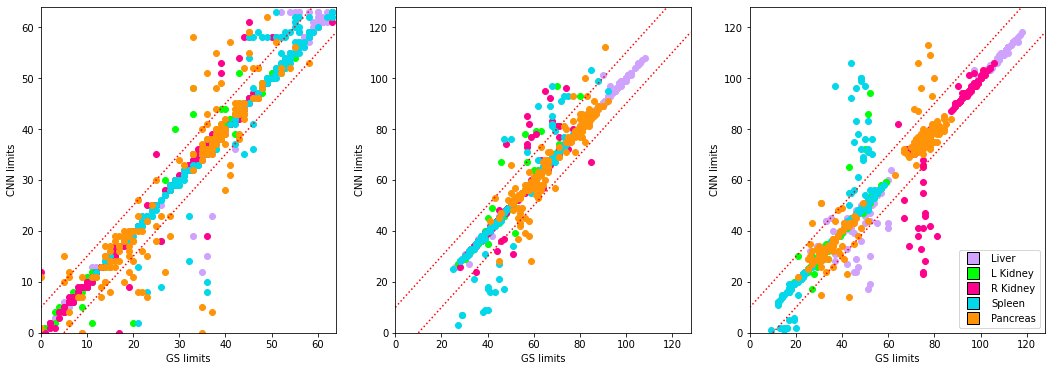

In [31]:
# crop out the top two slices for weird right kidney artefact
fnames = sorted(getFiles("/data/FLARE21/results/roughSegmenter/test_segs/"))
res = np.full((len(fnames), 5, 3, 2, 2), fill_value=np.nan)
for pdx, fname in enumerate(fnames):
    pred = np.load(os.path.join("/data/FLARE21/results/roughSegmenter/test_segs/", fname)).astype(float)
    gs = np.load(os.path.join("/data/FLARE21/training_data/scaled_masks/", fname.replace("pred_",""))).astype(float)
    pred[-2:][(pred==3)[-2:]] = 0 
    for ordx in range(1,6):
        if not (gs==ordx).any():
            continue
        for dirdx in range(3):
            res[pdx, ordx-1, dirdx, 0, 0] = np.min(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 0] = np.max(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 0, 1] = np.min(np.argwhere(pred==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 1] = np.max(np.argwhere(pred==ordx)[:,dirdx])

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(18,6))
axes = [ax0,ax1,ax2]
colors = ['xkcd:lilac', 'xkcd:bright green', 'xkcd:hot pink', 'xkcd:aqua blue', 'xkcd:tangerine']
for dirdx, ax in enumerate(axes):
    for ordx in range(5):
        ax.scatter(res[:,ordx,dirdx,0,0], res[:,ordx,dirdx,0,1], c=colors[ordx])#, marker='x', alpha=0.75, s=75)
        ax.scatter(res[:,ordx,dirdx,1,0], res[:,ordx,dirdx,1,1], c=colors[ordx])#, marker='^', alpha=0.75, s=75)
        ax.set_xlabel("GS limits")
        ax.set_ylabel("CNN limits")
# beautification
observers = ['Liver', 'L Kidney', 'R Kidney', 'Spleen', 'Pancreas']
m_s = []
for obdx, (color,label) in enumerate(zip(colors,observers)):
    m_s.append(mlines.Line2D([],[], mfc=color, mec='k', marker='s', linestyle='None', mew=1, markersize=12.5, label=label))
ax2.legend(handles=m_s, loc='lower right', ncol=1)
# plot bounds
ax0.plot([0,59],[5,64],'r:')
ax0.plot([5,64],[0,59],'r:')
ax1.plot([0,118],[10,128],'r:')
ax1.plot([10,128],[0,118],'r:')
ax2.plot([0,118],[10,128],'r:')
ax2.plot([10,128],[0,118],'r:')
ax0.set_xlim(0,64)
ax0.set_ylim(0,64)
ax1.set_xlim(0,128)
ax1.set_ylim(0,128)
ax2.set_xlim(0,128)
ax2.set_ylim(0,128)
plt.show()

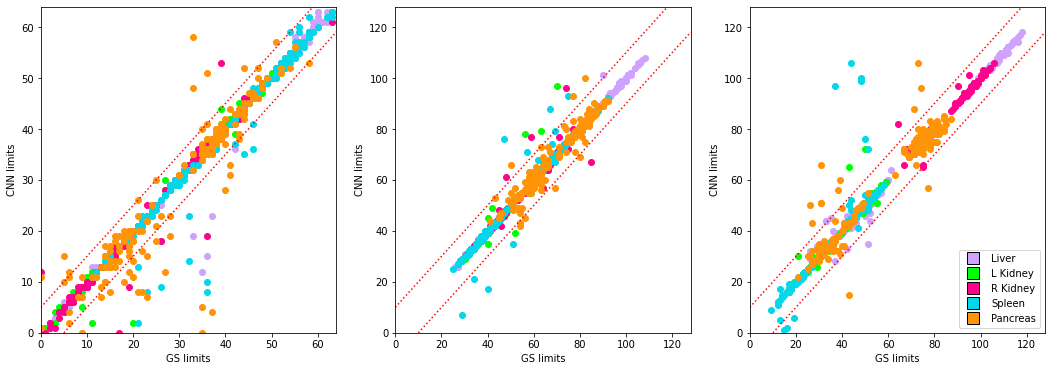

In [36]:
# use scipy.ndimage.label to get rid of any outlying random pixels
from scipy.ndimage import label

fnames = sorted(getFiles("/data/FLARE21/results/roughSegmenter/test_segs/"))
res = np.full((len(fnames), 5, 3, 2, 2), fill_value=np.nan)
for pdx, fname in enumerate(fnames):
    pred = np.load(os.path.join("/data/FLARE21/results/roughSegmenter/test_segs/", fname)).astype(float)
    gs = np.load(os.path.join("/data/FLARE21/training_data/scaled_masks/", fname.replace("pred_",""))).astype(float)
    pred[-2:][(pred==3)[-2:]] = 0
    for ordx in range(1,6):
        temp = (pred==ordx).astype(int)
        labels, num_features = label(temp)#, structure=np.ones((3,3,3)))
        if num_features > 1:
            #print(pdx, ordx, num_features)
            # disconnected bits present, iterate over them to check which to keep
            # if less than 45% the size of the primary, get rid
            for feature_label in range(2, num_features+1):
                if (labels==1).sum() * 0.45 > (labels==feature_label).sum():
                    pred[labels==feature_label] = 0
        if not (gs==ordx).any():
            continue
        for dirdx in range(3):
            res[pdx, ordx-1, dirdx, 0, 0] = np.min(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 0] = np.max(np.argwhere(gs==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 0, 1] = np.min(np.argwhere(pred==ordx)[:,dirdx])
            res[pdx, ordx-1, dirdx, 1, 1] = np.max(np.argwhere(pred==ordx)[:,dirdx])

fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(18,6))
axes = [ax0,ax1,ax2]
colors = ['xkcd:lilac', 'xkcd:bright green', 'xkcd:hot pink', 'xkcd:aqua blue', 'xkcd:tangerine']
for dirdx, ax in enumerate(axes):
    for ordx in range(5):
        ax.scatter(res[:,ordx,dirdx,0,0], res[:,ordx,dirdx,0,1], c=colors[ordx])#, marker='x', alpha=0.75, s=75)
        ax.scatter(res[:,ordx,dirdx,1,0], res[:,ordx,dirdx,1,1], c=colors[ordx])#, marker='^', alpha=0.75, s=75)
        ax.set_xlabel("GS limits")
        ax.set_ylabel("CNN limits")
# beautification
observers = ['Liver', 'L Kidney', 'R Kidney', 'Spleen', 'Pancreas']
m_s = []
for obdx, (color,label) in enumerate(zip(colors,observers)):
    m_s.append(mlines.Line2D([],[], mfc=color, mec='k', marker='s', linestyle='None', mew=1, markersize=12.5, label=label))
ax2.legend(handles=m_s, loc='lower right', ncol=1)
# plot bounds
ax0.plot([0,59],[5,64],'r:')
ax0.plot([5,64],[0,59],'r:')
ax1.plot([0,118],[10,128],'r:')
ax1.plot([10,128],[0,118],'r:')
ax2.plot([0,118],[10,128],'r:')
ax2.plot([10,128],[0,118],'r:')
ax0.set_xlim(0,64)
ax0.set_ylim(0,64)
ax1.set_xlim(0,128)
ax1.set_ylim(0,128)
ax2.set_xlim(0,128)
ax2.set_ylim(0,128)
plt.show()

In [ ]:
# For each OAR, check the GS lens in each dimension
fnames = sorted(getFiles("/data/FLARE21/results/roughSegmenter/test_segs/"))
res = np.full((len(fnames), 5, 3), fill_value=np.nan)
for pdx, fname in enumerate(fnames):
    gs = np.load(os.path.join("/data/FLARE21/training_data/scaled_masks/", fname.replace("pred_",""))).astype(float)
    for ordx in range(5):
        

for ordx in range(5):
        fig, (ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(18,6))
        
        plt.show()